In [ ]:
!pip install -q -U tensorflow-text
!pip install torchvision 
!pip install -q tf-models-official
!pip install transformers
!pip install emoji

     |████████████████████████████████| 4.6 MB 9.7 MB/s 
     |████████████████████████████████| 511.7 MB 5.7 kB/s 
     |████████████████████████████████| 5.8 MB 55.7 MB/s 
     |████████████████████████████████| 1.6 MB 8.8 MB/s 
     |████████████████████████████████| 438 kB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 7.1 MB/s 
     |████████████████████████████████| 636 kB 17.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 352 kB 46.5 MB/s 
     |████████████████████████████████| 99 kB 8.5 MB/s 
     |████████████████████████████████| 92 kB 10.6 MB/s 
     |████████████████████████████████| 237 kB 69.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.8 MB/s 
     |████████████████████████████████| 48.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.2 MB 50.6 MB/s 
Looking in indexes: https://pypi.org/si

In [ ]:
import os
import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

tf.get_logger().setLevel('ERROR')
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification,BertForSequenceClassification, BertTokenizer,  AdamW
from seqeval.metrics import classification_report
import pickle

import nltk
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

from nltk import word_tokenize
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch import cuda
device = 'cuda:0' if cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
import emoji
def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub("", text)

In [ ]:
path = '/content/drive/Shareddrives/CrimeTrack: Tracking Crime on the Web/Data/Train Dataset/training_dataset_labels.xlsx'

In [ ]:
file = pd.read_excel(path)

In [ ]:
file.head()

,username,creation_date,tweet,label,category,crime_type
0,guardiacivil,2017-10-13 20:00:02+00:00,"Es indiferente el evento, la fiesta, el lugar,...",Not Crime,0.0,NaN
1,guardiacivil,2022-01-07 14:00:00+00:00,El #ServicioAéreo y el #ServiciodeMontaña de l...,Not Crime,0.0,NaN
2,guardiacivil,2018-01-23 12:00:02+00:00,"""Paco"" arañó un vehículo cuando estaba aparcan...",Not Crime,0.0,NaN
3,guardiacivil,2021-06-03 14:00:00+00:00,Los requisitos específicos para participar en ...,Not Crime,0.0,NaN
4,guardiacivil,2018-01-16 08:00:01+00:00,"Esta semana el ""grajo va a volar muy bajo"", e ...",Not Crime,0.0,NaN


In [ ]:
file['tweet_processed'] = ''
for i in range(len(file)):
  file['tweet_processed'][i] = give_emoji_free_text(file.tweet[i])

In [ ]:
file.tweet[100]

'🔴 ¡IMPORTANTE! ⚠😈\n📣 5 cosas que no debes hacer con tus dispositivos electrónicos para evitar problemas de seguridad. 📱💻🖥 Echa un vistazo a la siguiente infografía de la @osiseguridad\n#SeguridadInternet ➕👇 \nhttps://t.co/nhHaSbq8Zc … … … …'

In [ ]:
file.tweet_processed[100]

' ¡IMPORTANTE! \n 5 cosas que no debes hacer con tus dispositivos electrónicos para evitar problemas de seguridad.  Echa un vistazo a la siguiente infografía de la @osiseguridad\n#SeguridadInternet  \nhttps://t.co/nhHaSbq8Zc … … … …'

In [ ]:
len(file)

4674

In [ ]:
file.label.unique()

array(['Not Crime', 'Crime'], dtype=object)

In [ ]:
file.category = file.category.astype(int)

In [ ]:
file.category.unique()

array([0, 1])

In [ ]:
print('Total Train Tweets:',len(file))
print('Total Train Crime Tweets:',len(file.loc[file['label'] == 'Crime']))
print('Total Train Not Crime Tweets:',len(file.loc[file['label'] == 'Not Crime']))

Total Train Tweets: 4674
Total Train Crime Tweets: 886
Total Train Not Crime Tweets: 3788


In [ ]:
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
max_length = 512

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

In [ ]:
give_emoji_free_text(file.tweet[4672])

'Detenido un yihadista dedicado a la captación de terroristas en una operación en #Toledo\n\nPoseía más de 60 manuales sobre la fabricación de #explosivos, la elaboración de venenos...\n\nAdemás realizaba discursos salafistas de alabanza a los mártires de la yihad https://t.co/IiN68FKOKe'

In [ ]:

print(file.tweet[4672],'\n')
encoding = tokenizer.encode(give_emoji_free_text(file.tweet[4672]),padding='max_length', max_length = 320, truncation=True, return_tensors="pt")
print('#######################\n')
print(tokenizer.convert_ids_to_tokens(encoding[0]))


🚩Detenido un yihadista dedicado a la captación de terroristas en una operación en #Toledo

Poseía más de 60 manuales sobre la fabricación de #explosivos, la elaboración de venenos...

Además realizaba discursos salafistas de alabanza a los mártires de la yihad https://t.co/IiN68FKOKe 

#######################

['[CLS]', 'detenido', 'un', 'yi', '##had', '##ista', 'dedicado', 'a', 'la', 'cap', '##tación', 'de', 'terroristas', 'en', 'una', 'operación', 'en', '[UNK]', 'toledo', 'poseía', 'más', 'de', '6', '##0', 'manuales', 'sobre', 'la', 'fabricación', 'de', '[UNK]', 'explosivos', ',', 'la', 'elaboración', 'de', 'veneno', '##s', '.', '.', '.', 'además', 'realizaba', 'discursos', 'sala', '##fis', '##tas', 'de', 'alab', '##anza', 'a', 'los', 'mártires', 'de', 'la', 'yi', '##had', 'h', '##tt', '##ps', ':', '/', '/', 't', '.', 'co', '/', 'ii', '##n', '##6', '##8', '##f', '##kok', '##e', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

In [ ]:
encoding = tokenizer.encode(give_emoji_free_text(file.tweet[4672]),padding='max_length', max_length = 320, truncation=True, return_tensors="pt")
encoding_ = tokenizer.encode(file.tweet[4672],padding='max_length', max_length = 320, truncation=True, return_tensors="pt")
print(tokenizer.convert_ids_to_tokens(encoding[0]))
print(tokenizer.convert_ids_to_tokens(encoding_[0]))

['[CLS]', 'detenido', 'un', 'yi', '##had', '##ista', 'dedicado', 'a', 'la', 'cap', '##tación', 'de', 'terroristas', 'en', 'una', 'operación', 'en', '[UNK]', 'toledo', 'poseía', 'más', 'de', '6', '##0', 'manuales', 'sobre', 'la', 'fabricación', 'de', '[UNK]', 'explosivos', ',', 'la', 'elaboración', 'de', 'veneno', '##s', '.', '.', '.', 'además', 'realizaba', 'discursos', 'sala', '##fis', '##tas', 'de', 'alab', '##anza', 'a', 'los', 'mártires', 'de', 'la', 'yi', '##had', 'h', '##tt', '##ps', ':', '/', '/', 't', '.', 'co', '/', 'ii', '##n', '##6', '##8', '##f', '##kok', '##e', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [ ]:
X = [tweet for tweet in file.tweet_processed]
y = [ label for label in file.category]

# splitting data from training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

print("X[0]:", X[0])
print("y[0]:", y[0])

print("Size X_train: ", len(X_train))
print("Size X_valid: ", len(X_valid))
print("Size X_test: ", len(X_test))

X[0]: Es indiferente el evento, la fiesta, el lugar, el día, la noche o la hora. Es simple:#NoEsNO
Ante cualquier agresión, no dudes Denuncia #062 https://t.co/V1E2cZFPfL
y[0]: 0
Size X_train:  3739
Size X_valid:  467
Size X_test:  468


In [ ]:
all_tags = sorted(set(['Not Crime', 'Crime']), reverse=True)
num_tags = len(all_tags)
print("Number of tags:", num_tags)
print("Tags:", all_tags)

Number of tags: 2
Tags: ['Not Crime', 'Crime']


In [ ]:
tag2index = {tag: i for i, tag in enumerate(all_tags)}
index2tag = {i: tag for tag, i in tag2index.items()}

In [ ]:
print(index2tag)

{0: 'Not Crime', 1: 'Crime'}


In [ ]:
class dataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
        self.len = len(X)
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __len__(self):
        return self.len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        text = self.X[index]
        label = self.y[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        encoding = self.tokenizer(text,
                             padding='max_length', max_length = self.max_len, 
                              truncation=True, return_tensors="pt")
        encoding['label'] = torch.tensor(label)
        return encoding

In [ ]:
max_seq_len = 128
training_set = dataset(X_train, y_train, tokenizer, max_seq_len)
validation_set = dataset(X_valid, y_valid, tokenizer, max_seq_len)
testing_set = dataset(X_test, y_test, tokenizer, max_seq_len)

In [ ]:
training_set[14]

{'input_ids': tensor([[    4, 21673,  5251,  1035, 17521,  1091,  2946,  1041, 24954,  1152,
          1012,  4773,  5590,  1048,  8288, 11061,  1009,  3171,  1097, 10939,
          1007,  6716,   995,  1413, 10971,     5,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

In [ ]:
tokenizer.decode(training_set[14]['input_ids'][0])

'[CLS] desmantelada en salamanca una red que estafaba a centros comerciales con documentación falsa de empresas para tarjetas d compra : 5 detenidos [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
max_seq_len = max([len(x) for x in X])
print("max_seq_leng:", max_seq_len)

max_seq_leng: 312


In [ ]:
training_set[0]["label"]

tensor(0)

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(tag2index))
model = model.to(device)

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [ ]:
TRAIN_BATCH_SIZE = 30
VALID_BATCH_SIZE = 30
EPOCHS = 10

training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=VALID_BATCH_SIZE, shuffle=False)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
inputs = { key: training_set[:10][key] for key in ['input_ids','token_type_ids','attention_mask','label'] }
ids = inputs['input_ids'].to(device)
mask = inputs['attention_mask'].to(device)

labels =inputs['label'].to(device)
outputs = model(input_ids=ids,attention_mask=mask,labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(0.6982, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
tr_logits = outputs[1]
tr_logits

tensor([[-0.0607, -0.1190],
        [ 0.1414,  0.0713],
        [ 0.2884, -0.0322],
        [ 0.1173, -0.0308],
        [ 0.0928, -0.0651],
        [-0.1497, -0.0789],
        [ 0.0025, -0.1095],
        [ 0.0676, -0.0313],
        [ 0.0192,  0.1229],
        [ 0.2017,  0.0078]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8 )

In [ ]:
from pandas._libs.index import BaseMultiIndexCodesEngine
def valid(model, data_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):

            ids = batch['input_ids'].squeeze().to(device)
            mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=ids,attention_mask=mask,labels=labels)  
            loss = outputs[0]
            eval_logits = outputs[1]
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
      
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [index2tag[id.item()] for id in eval_labels]
    predictions = [index2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    # print(f"Validation : loss {eval_loss:.2f} accuracy {eval_accuracy:.2f}")

    return labels, predictions, eval_loss, eval_accuracy

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    with tqdm(training_loader, 'batch') as tepoch:
        for idx, batch in enumerate(tepoch):
            tepoch.set_description(f'Epoch {epoch}')
            
            ids = batch['input_ids'].squeeze().to(device)
            mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=ids,attention_mask=mask,labels=labels)  

            loss, tr_logits = outputs[0], outputs[1]
            tr_loss += loss.item()

            nb_tr_steps += 1
            nb_tr_examples += labels.size(0)
            
            # if idx % 100==0:
            #     loss_step = tr_loss/nb_tr_steps
            #     print(f"Training loss per 100 training steps: {loss_step:.2f}")
            
            # compute training accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

    
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
            #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
            
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            tr_labels.extend(labels)
            tr_preds.extend(predictions)

            tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            tr_accuracy += tmp_tr_accuracy
        
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=10)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=tr_loss / nb_tr_steps, accuracy=tr_accuracy / nb_tr_steps)
    
    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
              
    _, _ , val_loss, val_acc = valid(model, validation_loader)
    
    return epoch_loss, tr_accuracy, val_loss, val_acc

In [ ]:
history = {'train_loss':[], 'train_accuracy':[], 'val_loss':[], 'val_accuracy':[], 'epoch':[]}
for epoch in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(epoch)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['epoch'].append(epoch+1)

Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

flattened_targets tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0], device='cuda:0')
active_logits tensor([[ 0.0273,  0.0203],
        [-0.0325, -0.1528],
        [ 0.1261, -0.1483],
        [ 0.1134, -0.0871],
        [-0.1757, -0.0754],
        [-0.1640, -0.0559],
        [-0.0584, -0.2489],
        [ 0.2135, -0.0043],
        [ 0.0482, -0.0058],
        [ 0.1012,  0.2291],
        [ 0.1772,  0.0309],
        [ 0.0343,  0.0316],
        [ 0.0883, -0.0725],
        [-0.0139, -0.1700],
        [ 0.2461,  0.0672],
        [ 0.0355, -0.1007],
        [ 0.0837, -0.1162],
        [ 0.1101,  0.0608],
        [ 0.0751,  0.0047],
        [ 0.0107,  0.0384],
        [ 0.0866,  0.0388],
        [ 0.1095,  0.0938],
        [ 0.1596,  0.0967],
        [ 0.0693,  0.1348],
        [ 0.0261, -0.1623],
        [-0.0775, -0.1954],
        [ 0.0964,  0.0179],
        [ 0.0586, -0.0139],
        [ 0.0776, -0.0537],
        [ 0.1686, -0.0418]], dev

Epoch 0:   1%|          | 1/125 [00:00<01:26,  1.43it/s, accuracy=0.633, loss=0.674]

flattened_targets tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], device='cuda:0')
active_logits tensor([[ 0.4945, -0.4246],
        [ 0.2698, -0.3283],
        [ 0.2290, -0.4421],
        [ 0.3252, -0.2426],
        [ 0.1354, -0.2479],
        [ 0.3962, -0.3092],
        [ 0.4924, -0.5445],
        [ 0.1017, -0.2469],
        [ 0.2985, -0.2697],
        [-0.0183, -0.3041],
        [ 0.0150,  0.1394],
        [ 0.4836, -0.3886],
        [ 0.2542, -0.2026],
        [ 0.2508, -0.5230],
        [ 0.3093, -0.2100],
        [ 0.5015, -0.3686],
        [ 0.3813, -0.4631],
        [ 0.2564, -0.4820],
        [ 0.2686, -0.5296],
        [ 0.2742, -0.4400],
        [ 0.4989, -0.3713],
        [ 0.3934, -0.5343],
        [ 0.4942, -0.4443],
        [ 0.6027, -0.4589],
        [ 0.4233, -0.3785],
        [ 0.3516, -0.3449],
        [ 0.2119, -0.3813],
        [ 0.2503, -0.4405],
        [ 0.4125, -0.3421],
        [ 0.4051, -0.3700]], dev

Epoch 0:   2%|▏         | 2/125 [00:01<01:23,  1.47it/s, accuracy=0.733, loss=0.587]

flattened_targets tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0], device='cuda:0')
active_logits tensor([[ 0.5253, -0.5764],
        [ 0.4330, -0.6718],
        [ 0.5820, -0.7460],
        [ 0.5481, -0.6609],
        [ 0.7148, -0.9580],
        [ 0.5403, -0.6848],
        [ 0.3506, -0.3162],
        [ 0.6166, -0.8116],
        [ 0.4388, -0.9738],
        [ 0.5628, -0.6097],
        [ 0.5920, -0.7263],
        [ 0.2254, -0.2549],
        [ 0.4747, -0.7000],
        [ 0.6728, -0.7568],
        [ 0.5737, -0.7402],
        [ 0.6216, -0.6977],
        [ 0.6608, -0.7229],
        [ 0.5702, -0.7126],
        [ 0.6703, -0.7536],
        [ 0.5680, -0.7720],
        [ 0.4943, -0.7594],
        [ 0.6714, -0.7731],
        [ 0.6655, -0.5526],
        [ 0.8331, -0.6006],
        [ 0.4826, -0.1045],
        [ 0.5025, -0.8494],
        [ 0.4801, -0.6600],
        [ 0.3652, -0.5899],
        [ 0.4687, -0.1735],
        [ 0.6339, -0.6341]], dev

Epoch 0:   2%|▏         | 3/125 [00:02<01:21,  1.49it/s, accuracy=0.767, loss=0.53]

flattened_targets tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0], device='cuda:0')
active_logits tensor([[ 0.2205, -0.3766],
        [ 0.7143, -0.9473],
        [ 0.6223, -1.0085],
        [ 0.6384, -1.0484],
        [ 0.6289, -0.9204],
        [ 0.8926, -1.0421],
        [ 0.8830, -0.9948],
        [ 0.5117, -0.7243],
        [ 0.4860, -0.7734],
        [ 0.6654, -1.1416],
        [ 0.7364, -1.2806],
        [ 0.7438, -0.8343],
        [ 0.7732, -1.0462],
        [ 0.7105, -1.0137],
        [ 0.8342, -1.0632],
        [ 0.5163, -0.9683],
        [ 0.2853, -0.4774],
        [ 0.8091, -1.0242],
        [ 0.7941, -1.0865],
        [ 0.7248, -0.7964],
        [ 0.7545, -1.0219],
        [ 0.4303, -0.3367],
        [ 0.7303, -0.9139],
        [ 0.9290, -0.9441],
        [ 0.4479, -0.6789],
        [ 0.7397, -1.1424],
        [ 0.6683, -1.0042],
        [ 0.8567, -0.9615],
        [ 0.6600, -0.5815],
        [ 0.9635, -1.0814]], dev

Epoch 0:   3%|▎         | 4/125 [00:02<01:17,  1.56it/s, accuracy=0.783, loss=0.487]

flattened_targets tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0], device='cuda:0')
active_logits tensor([[ 0.6816, -0.7346],
        [ 0.9021, -0.9997],
        [ 0.9100, -1.1115],
        [ 0.8038, -1.0470],
        [ 0.7427, -0.5973],
        [ 0.6879, -0.9135],
        [ 0.9194, -1.1282],
        [ 0.8967, -1.0117],
        [ 0.9897, -1.3289],
        [ 0.6351, -0.9060],
        [ 0.5376, -0.8001],
        [ 0.7341, -1.0266],
        [ 0.8986, -0.9729],
        [ 0.9155, -1.2606],
        [ 1.0467, -1.2249],
        [ 0.8834, -1.1084],
        [ 0.8130, -1.0279],
        [ 1.1126, -1.2742],
        [ 0.7600, -0.8468],
        [ 0.9513, -1.2379],
        [ 0.7650, -0.9146],
        [ 0.7570, -1.3042],
        [ 0.8432, -1.4055],
        [ 0.9886, -1.2094],
        [ 1.1796, -1.3275],
        [ 0.4765, -0.6491],
        [ 0.4189, -0.3872],
        [ 0.3598, -0.5013],
        [ 0.9879, -1.2379],
        [ 0.8151, -1.0597]], dev

Epoch 0:   4%|▍         | 5/125 [00:03<01:14,  1.61it/s, accuracy=0.807, loss=0.442]

flattened_targets tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], device='cuda:0')
active_logits tensor([[ 0.8611, -1.1308],
        [ 1.2409, -1.4408],
        [ 1.1385, -1.2589],
        [ 0.5914, -0.4683],
        [ 0.1411, -0.3373],
        [ 0.9938, -1.4023],
        [ 0.8475, -1.4652],
        [ 0.9729, -1.4326],
        [ 0.1210, -0.3661],
        [ 0.6659, -0.4424],
        [ 1.0570, -1.5367],
        [ 0.5457, -1.0030],
        [ 0.5731, -0.4147],
        [ 0.8927, -1.4298],
        [ 1.0029, -1.2507],
        [ 0.8576, -1.5379],
        [-0.2190, -0.2045],
        [ 0.2861, -0.1596],
        [ 0.9948, -1.2259],
        [ 0.9599, -1.2273],
        [ 1.1367, -1.4765],
        [ 1.0187, -1.3382],
        [ 1.0971, -1.3306],
        [ 0.9664, -1.3889],
        [ 0.7041, -0.6647],
        [ 0.9541, -1.4436],
        [ 0.7164, -0.8672],
        [ 0.7261, -0.8468],
        [ 0.7071, -0.7924],
        [ 1.2873, -1.3601]], dev

Epoch 0:   5%|▍         | 6/125 [00:03<01:12,  1.64it/s, accuracy=0.806, loss=0.432]

flattened_targets tensor([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 1], device='cuda:0')
active_logits tensor([[ 0.3520, -0.6342],
        [ 1.1477, -1.2381],
        [ 0.1255, -0.4305],
        [ 0.4824, -0.8347],
        [ 0.3588, -0.9025],
        [ 1.0326, -1.2763],
        [ 0.7636, -1.3636],
        [ 1.1363, -1.6918],
        [ 0.1197, -0.2066],
        [ 0.9831, -1.2952],
        [ 0.9585, -1.4343],
        [ 0.9517, -1.3366],
        [ 0.9232, -1.3411],
        [ 0.7245, -0.8830],
        [ 1.0399, -1.4036],
        [ 0.9520, -1.5293],
        [ 0.6191, -0.8935],
        [ 1.0604, -1.4843],
        [ 1.2099, -1.4113],
        [ 0.7532, -0.7895],
        [ 0.8612, -1.0408],
        [ 1.0371, -1.3971],
        [ 0.2581, -0.2753],
        [ 0.7486, -0.6078],
        [ 0.0993,  0.0408],
        [ 0.6045, -0.8604],
        [-0.0574, -0.3237],
        [ 1.1289, -1.3929],
        [ 1.2882, -1.2247],
        [ 0.4898, -0.3990]], dev

Epoch 0:   6%|▌         | 7/125 [00:04<01:11,  1.66it/s, accuracy=0.795, loss=0.424]

flattened_targets tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1], device='cuda:0')
active_logits tensor([[ 3.1919e-01, -4.0631e-01],
        [ 1.3127e+00, -1.2127e+00],
        [ 8.5995e-01, -1.2777e+00],
        [ 1.1360e+00, -1.4367e+00],
        [ 3.3277e-01, -5.0003e-01],
        [ 1.6036e-01, -5.2003e-01],
        [ 8.6977e-01, -8.5059e-01],
        [ 1.0533e+00, -1.0561e+00],
        [ 8.4853e-01, -1.3396e+00],
        [-4.1757e-02,  2.5318e-01],
        [ 1.0025e+00, -1.1214e+00],
        [-7.6421e-02,  1.2906e-01],
        [ 1.6964e-01, -1.7707e-04],
        [ 1.0170e+00, -1.2848e+00],
        [ 5.2949e-01, -9.7670e-01],
        [ 6.7922e-01, -6.3823e-01],
        [ 5.0862e-01, -1.5323e-01],
        [ 1.0294e+00, -1.3059e+00],
        [ 5.7100e-01, -1.0765e+00],
        [ 5.3149e-02, -1.0269e-01],
        [ 8.9283e-01, -9.9743e-01],
        [ 6.4977e-01, -7.5573e-01],
        [ 5.7599e-01, -8.5576e-01],
        [ 1.6445

Epoch 0:   6%|▋         | 8/125 [00:05<01:09,  1.67it/s, accuracy=0.8, loss=0.421]

flattened_targets tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0], device='cuda:0')
active_logits tensor([[ 0.9536, -1.1138],
        [ 0.6974, -1.1315],
        [-0.3486,  0.1113],
        [ 1.0218, -1.1176],
        [ 1.3082, -1.5689],
        [ 0.8392, -1.0735],
        [ 0.6141, -0.7502],
        [ 0.7901, -1.3790],
        [ 0.5686, -0.6710],
        [ 0.5550, -1.0974],
        [ 0.9039, -1.4182],
        [ 0.4436, -0.2323],
        [ 0.3818, -0.7860],
        [-0.2130,  0.4283],
        [-0.0447, -0.1024],
        [ 1.3072, -1.5982],
        [ 1.1287, -1.3947],
        [ 0.7468, -1.1439],
        [ 0.5614, -0.6376],
        [ 0.8063, -1.3632],
        [ 0.7340, -0.9894],
        [-0.4718,  0.3367],
        [ 0.3666, -0.7365],
        [ 0.6339, -1.0499],
        [ 0.9852, -1.2500],
        [ 0.8986, -1.1760],
        [ 1.1006, -1.5468],
        [ 0.8490, -1.0270],
        [ 1.0890, -1.4694],
        [ 0.7507, -1.1946]], dev

Epoch 0:   7%|▋         | 9/125 [00:05<01:08,  1.68it/s, accuracy=0.822, loss=0.396]

flattened_targets tensor([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0], device='cuda:0')
active_logits tensor([[ 0.2037, -0.3108],
        [ 0.9038, -1.2358],
        [-0.6107,  0.6834],
        [ 0.2049, -0.7780],
        [-0.2864,  0.2323],
        [ 1.3968, -1.2824],
        [-0.1447,  0.1271],
        [ 1.0449, -1.3813],
        [-0.0377,  0.1714],
        [ 1.3009, -1.7319],
        [ 1.0064, -1.2140],
        [ 0.0277,  0.0880],
        [ 0.5955, -0.3635],
        [ 1.3211, -1.6057],
        [-0.3593,  0.2764],
        [ 1.2256, -1.5625],
        [ 0.3926, -0.2322],
        [ 1.1974, -1.5803],
        [ 0.9524, -1.2902],
        [ 1.0857, -1.4628],
        [ 0.9286, -1.3926],
        [-0.5191,  0.2469],
        [ 0.2594, -0.6847],
        [ 0.1155, -0.5324],
        [-0.2707,  0.1150],
        [ 0.3432, -0.1309],
        [-0.1931,  0.4424],
        [ 0.7216, -1.2579],
        [ 1.4268, -1.5578],
        [ 1.3702, -1.7934]], dev

Epoch 0:   8%|▊         | 10/125 [00:06<01:13,  1.57it/s, accuracy=0.83, loss=0.388]


KeyboardInterrupt: ignored

<function matplotlib.pyplot.show>

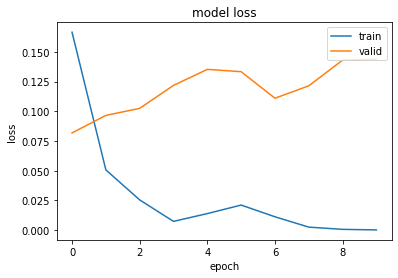

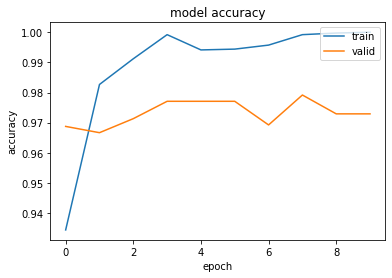

In [ ]:
plt.figure(1)
plt.plot(history[f'train_loss'])
plt.plot(history[f'val_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

plt.figure(2)
plt.plot(history[f'train_accuracy'])
plt.plot(history[f'val_accuracy'])
plt.title(f'model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

In [ ]:
from sklearn.metrics import classification_report

labels, predictions, loss, accuracy = valid(model, testing_loader)
print(f"Validation : loss {loss:.2f} accuracy {accuracy:.2f}")
print(classification_report(labels, predictions))

Validation : loss 0.15 accuracy 0.97
              precision    recall  f1-score   support

       Crime       0.92      0.95      0.93        93
   Not Crime       0.99      0.98      0.98       375

    accuracy                           0.97       468
   macro avg       0.95      0.96      0.96       468
weighted avg       0.97      0.97      0.97       468



In [ ]:
not_classified = []
for i in range(len(labels)): 
  if labels[i] != predictions[i]:
    not_classified.append(i)  

In [ ]:
len(not_classified)

13

In [ ]:
def inference(sentence, tokenizer):
    inputs = tokenizer(sentence,padding='max_length', max_length = 128, truncation=True, return_tensors="pt")

    # move to gpu
    ids = inputs["input_ids"].to(device)
    mask = inputs["attention_mask"].to(device)
    # forward pass
    outputs = model(ids, attention_mask=mask)
    logits = outputs[0]

    active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    
    token_predictions = [index2tag[i] for i in flattened_predictions.cpu().numpy()]

    return token_predictions

In [ ]:
for i in range(len(not_classified)):
  sentence = X_test[not_classified[i]]
  print('Tweet:', sentence)
  print('Label:', y_test[not_classified[i]])
  entities = inference(sentence,tokenizer)
  print('Prediction:',entities)
  print('################')

Tweet: Recibes un SMS: estás "fichado" como moroso. Peeero si quieres ser borrado, lo puedes lograr llamando a un tfno de alta tarificación #FRAUDE
Label: 0
Prediction: ['Crime']
################
Tweet: Felicito a estos policías qu salvan a un perro maltratado cruelmente, detienen al autor y pagan la operación
@policia http://t.co/sSZuYAorvc
Label: 1
Prediction: ['Not Crime']
################
Tweet: Si recibes un mensaje de de una entidad bancaria advirtiendo de que tu cuenta bancaria ha sido bloqueada...
 
¡NO PIQUES!

No facilites tus datos a través de enlaces de procedencia desconocida

#Phishing https://t.co/3p6dzAX1vA
Label: 0
Prediction: ['Crime']
################
Tweet: Qué bien te vendrían 500 € para gastártelos en trapitos, verdad? No piques! #FRAUDE http://t.co/9Z2sFbp3cT
Label: 1
Prediction: ['Not Crime']
################
Tweet: ¿Un@ amig@ de @facebook te envía un mensaje preguntándote si eres la persona que sale en un video al que lleva un link?
#NiCaso,  #SiHacesClicYaNoHa

In [ ]:
print(entities)

['Not Crime']


# Nueva sección

In [ ]:
directory = Path("/content/drive/Shareddrives/CrimeTrack: Tracking Crime on the Web/Model/Model Crime Not Crime Classification_97_2")
directory.mkdir(parents=True, exist_ok=True)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(str(directory))
# save the model weights and its configuration file
model.save_pretrained(directory)

parameters = (max_seq_len, all_tags, tag2index, index2tag)
pickle.dump(parameters, (directory / 'parrameters.pk').open('wb'))

print('All files saved')

All files saved
